# Non-parametric physiological classification of retinal ganglion cells

by Jonathan Jouty (1), Gerrit Hilgen (2), Evelyne Sernagor (2), Matthias H. Hennig (1)

(1) Institute for Adaptive and Neural Computation, University of Edinburgh, School of Informatics, 10 Crichton St, Edinburgh, EH8 9AB, United Kingdom
(2) Institute of Neuroscience, Newcastle University, Newcastle, NE2 4HH, United Kingdom

This notebook reproduces the analysis of the RGC data set, as hown in this [https://www.biorxiv.org/content/early/2018/09/04/407635).

The anaysis consist of the following steps:

- import sorted spike trains (spike sorting was performed with [HS2](https://github.com/mhhennig/HS2))
- perform a spike sorting quality control, only retian units that pass certain quality criteria
- compute spike distance matrices or load the pre-computed matrix (note computing distances takes a while to run, on 48 cores about 18 minutes)
- import STAs, and optionally filter out units with poor STA fit (note this may filter out valid neurons, this step is omitted in the example shown in the paper)
- perform hierarchical agglomerative clustering and visualise the results

[mm](mmmm)

# Parameters

In [1]:
# Recording
notebooks_path = "./"
data_path = notebooks_path 
filenames = ['P91_05_07_17_basicshort_stim1_ctl_clustered.hdf5']

# stimulus information
report_filenames  = [ data_path+"Report_2017-07-05_13_25_30_ProtocolName_Basic_Exp_stim1.txt" ]
trigger_filenames = [ data_path+"Trigger_stim1_basic_ctl.mat" ]

# Set to False to reload the spike data from the original hdf5 files 
LOAD_STORED_SPIKES = True

# Set to False to re-compute the distance matrices
LOAD_STORED_DISTANCES = True

# Unit selection

# estimate the spatial spread of spikes for each unit
# poorly sorted units have a wide spread and/or high eccentricity
EVAL_THRES = 0.17 # threshold for average spread
ECC_THRES = 0.85 # threshold for eccentricity

# exclude units with insufficient spike counts (per trial)
MIN_SPIKES_FF = 0 # min spikes in Full Field stimulus
MIN_SPIKES_CHIRP = 10 # min spikes in Chirp stimulus

# set to True to apply an additional fiilter based on the STA
# note this excludes units without a valid STA
# we found not all RGCs have a clean STA, so this will exclude valid neurons
# doing this reduces the number of clusters considerably
FILTER_STA = False
STA_MAX_DIST = 0.7
STA_MAX_ASYM = 0.9

# set to True to save the figures generated below
SAVE_FIGS = False

# Required imports

In [2]:
import os.path, sys

%pylab inline

from herdingspikes import *
from spikeclass_metrics import *

import numpy as np
import seaborn as sns
import matplotlib as matplotlib

import re
import h5py
import pyspike as spk

import joblib

import scipy.cluster as cluster
import scipy.spatial.distance as distance
from scipy.spatial.distance import squareform
import sklearn.metrics.cluster as metrics
from sklearn.metrics import confusion_matrix

from sta import *
from spikeutilities import *

# plot parameters
rcParams = {
   'axes.labelsize': 12,
   'font.size': 10,
   'legend.fontsize': 12,
   'xtick.labelsize': 12,
   'ytick.labelsize': 12,
   'text.usetex': False,
   'figure.figsize': [4, 2.5] # instead of 4.5, 4.5
   }

Populating the interactive namespace from numpy and matplotlib


# Load data

## Read spikes

In [3]:
get_cluster_inds = lambda C, cl: np.where(C==cl)[0]

i = 0
base_path = data_path + filenames[i]
base_path = base_path.replace('.hdf5','__save_.npy')
mkp = lambda n: base_path.replace('_.npy','_'+n+'.npy')

# Stuff that will be filled from spikeclass
Times = {}
ClusterIDs = {}
ClusterLoc = {}
ClusterSizes = {}
# Stuff we want to compute
sCorrs = {}
ClusterEvals = {}

if LOAD_STORED_SPIKES == False:

    for i,f in enumerate(filenames):
        sf = data_path + f
        print(i,sf)
        O = spikeclass(sf)
        Sampling = O.Sampling()
        ncl = O.NClusters()
        print("  has %s clusters. Sampling is %s." % (ncl,Sampling))

        Times[i] = O.Times()
        ClusterIDs[i] = O.ClusterID()
        ClusterLoc[i] = O.ClusterLoc()
        ClusterSizes[i] = O.ClusterSizes()

        # correlation between spike waveforms
        sCorrs[i] = clusters_median_correlation(O)

        # to take sorting errors into account,
        # we take the spatial spread of the spikes, and only include units that are well localised
        unit_evals = np.zeros((ncl, 2))
        loc = O.Locations()
        for cl in range(ncl):
            inds = get_cluster_inds(O.ClusterID(),cl)
            unit_evals[cl, :] = np.linalg.eigvalsh(np.cov(loc[:,inds]))
        ClusterEvals[i] = unit_evals
        
        del O
        
    # store for re-use

    for i in range(len(filenames)):
      base_path = data_path + filenames[i]
      base_path = base_path.replace('.hdf5','__save_.npy')
      mkp = lambda n: base_path.replace('_.npy','_'+n+'.npy')

      np.save(mkp('Times'),Times[i])
      np.save(mkp('ClusterIDs'),ClusterIDs[i])
      np.save(mkp('ClusterLoc'),ClusterLoc[i])
      np.save(mkp('ClusterSizes'),ClusterSizes[i])
      np.save(mkp('sCorrs'),sCorrs[i])
      np.save(mkp('ClusterEvals'),ClusterEvals[i])

      print('Saved set %s.' % i)

else:
    
    for i in range(len(filenames)):
        Times[i] = np.load(mkp('Times'))
        ClusterIDs[i] = np.load(mkp('ClusterIDs'))
        ClusterLoc[i] = np.load(mkp('ClusterLoc'))
        ClusterSizes[i] = np.load(mkp('ClusterSizes'))
        sCorrs[i] = np.load(mkp('sCorrs'))
        ClusterEvals[i] = np.load(mkp('ClusterEvals'))

    print('Loaded set %s.' % i)
    
ncl = ClusterSizes[0].shape[0]
print("Number of units: %d" % ncl)
Sampling = 7062.058198545425 # copied from previous output

Loaded set 0.
Number of units: 9817


## Read stimulus info

In [4]:
Stimuli = {}
timeStampMatrices = {}

for ix,(rf,tf) in enumerate(zip(report_filenames,trigger_filenames)):
    print("Reading file set %s: %s, %s" % (ix,rf,tf))
    Stimuli[ix], timeStampMatrices[ix] = read_stimuli_info(rf,tf)

stim_ntrials = []
for i,name in enumerate(Stimuli[0]['Name']):
    nstim1 = Stimuli[0]['Nstim1'][i]
    ntrials = 0.1

    if 'Fullfield' in name:
        ntrials = nstim1/2
    elif 'chirp2' in name:
        ntrials = nstim1/1016
    elif 'movingbar' in name:
        ntrials = nstim1/143
    elif 'Bar' in name:
        ntrials = 5.0
    else:
        print("Unknown stimulus name: %s." % name)
        raise Exception

    if not float.is_integer(ntrials):
        print("Something went wrong with %s, ntrials is not an integer: %f" %(name,ntrials))

    stim_ntrials.append(int(ntrials))

for ix in range(len(Stimuli)):
    Stimuli[ix]['NTrials'] = stim_ntrials

Reading file set 0: ./Report_2017-07-05_13_25_30_ProtocolName_Basic_Exp_stim1.txt, ./Trigger_stim1_basic_ctl.mat
Not closed: used loadmat


## Convert spile times to PySpike format

In [5]:
%%time

SpikeTimes = {}
for ix in range(len(ClusterIDs)):
  SpikeTimes[ix] = []
  for cl in range(ncl):
    cl_spikes = np.where(ClusterIDs[ix]==cl)[0]
    cl_times  = np.unique(Times[ix][cl_spikes])
    SpikeTimes[ix].append(cl_times)

for ix in range(len(ClusterIDs)):
  STs = []
  for stimid in Stimuli[ix].index:
    stim_trains = []
    # figure out how long each stimulus is
    n_trials    = Stimuli[ix]['NTrials'][stimid]
    stim_img_n  = Stimuli[ix]['Nstim1'][stimid] / n_trials
    stim_img_ms = Stimuli[ix]['Nrefresh'][stimid] * (1000/60)
    stim_dur    = np.ceil(stim_img_ms * (Sampling/1000) * stim_img_n)
    # get the stimulus start times and reshape to [n_trials,-1]
    stim_start_end = get_stimtimes(stimid, Stimuli[ix], timeStampMatrices[ix]).reshape([n_trials,-1])

    for cl in range(ncl):
      cl_trains = []
      # use pre-filtered cluster times, avoids doing it every time
      cl_times = SpikeTimes[ix][cl]
      for tx in range(stim_start_end.shape[0]):
        s0 = stim_start_end[tx,0]
        s1 = s0 + stim_dur
        trial_filter = np.where((cl_times >= s0) & (cl_times <= s1))[0]
        trial_times  = cl_times[trial_filter] - s0
        trial_times  = trial_times / (Sampling/1000)
        st = spk.SpikeTrain(trial_times, stim_dur/(Sampling/1000))
        cl_trains.append(st)
      stim_trains.append(cl_trains)
    STs.append(np.asarray(stim_trains))
  Stimuli[ix]['SpikeTrains'] = STs
  del STs

CPU times: user 1min 50s, sys: 4.45 s, total: 1min 54s
Wall time: 1min 54s


# Apply Spike Sorting Quality Criteria

Valid units: 3587


/disk/scratch/mhennig/venvs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in less_equal
  """
/disk/scratch/mhennig/venvs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in less_equal
  


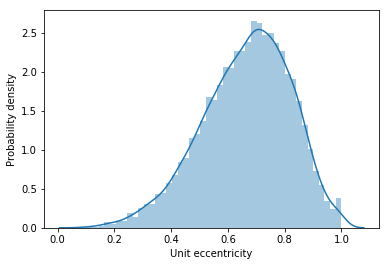

<Figure size 432x288 with 0 Axes>

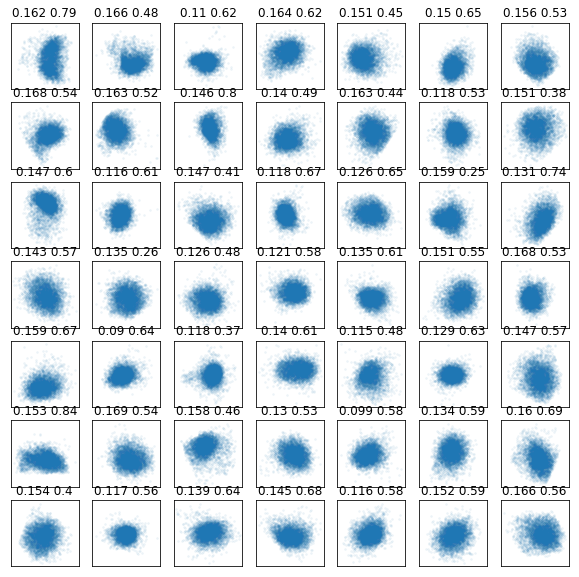

In [6]:
eccentricity = lambda l: np.sqrt(1-np.min(l)/np.max(l))  

inds = ~isnan(ClusterEvals[0])
eccs = np.array([eccentricity(c) for c in ClusterEvals[0]])
valid_units = np.sqrt(np.mean(ClusterEvals[0],axis=1))<=EVAL_THRES
valid_units = valid_units * (eccs<=ECC_THRES)
print("Valid units: %d" %np.sum(valid_units))

plt.figure()
sns.distplot(eccs[~isnan(eccs)])
plt.xlabel('Unit eccentricity')
plt.ylabel('Probability density')
plt.figure()

# plot a sample of valid units
O = spikeclass(data_path + filenames[0])
loc = O.Locations()
plt.figure(figsize=(10,10))
cl = 9
for i,cl in enumerate(np.where(valid_units)[0][:49]):
    plt.subplot(7,7,i+1)
    inds = get_cluster_inds(O.ClusterID(),cl)[:5000]
    plt.scatter(loc[0,inds],loc[1,inds], alpha=0.05,s=3)
    plt.axis('equal')
    plt.title(str(np.round(np.mean(np.sqrt(ClusterEvals[0][cl])),3))+' '+str(np.round(eccentricity(ClusterEvals[0][cl]),2)))
    plt.xticks(())
    plt.yticks(())

del O

Valid units remaining: 1101


Text(0.5,1,'Invalid units')

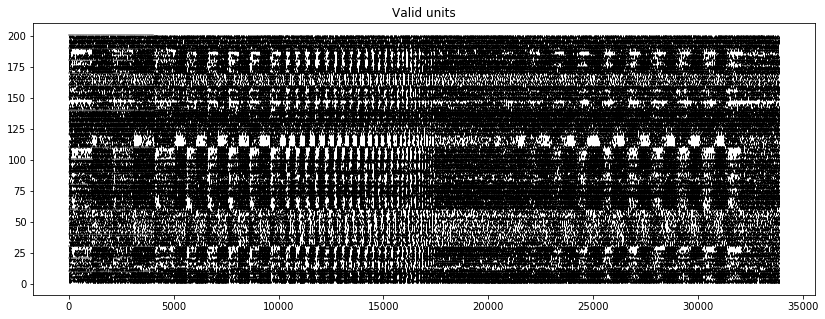

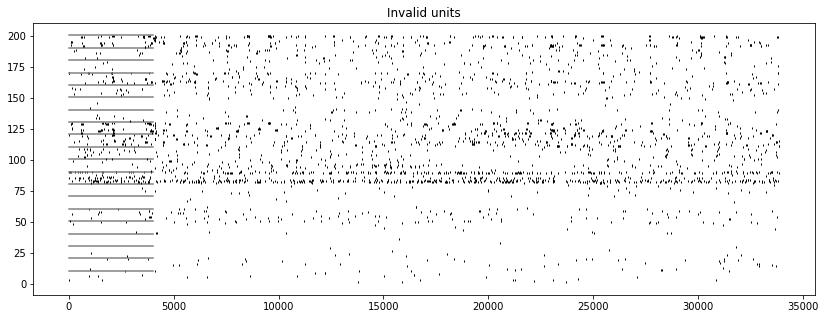

In [7]:
# exclude units with insufficient spike counts (per trial)

empty_trials = {}
# spike count in each full field trial
empty_trials[0] = np.asarray([np.min([len(s) for s in st])<MIN_SPIKES_FF for st in Stimuli[0]['SpikeTrains'][0]])
# spike count in each chirp trial
empty_trials[1] = np.asarray([np.min([len(s) for s in st])<MIN_SPIKES_CHIRP for st in Stimuli[0]['SpikeTrains'][1]])
conditions = (~np.asarray(empty_trials[0]|empty_trials[1]))*valid_units
print("Valid units remaining: %d" %np.sum(conditions))

# example rasters of filtered units
istim = 1 # 0 for full field, 1 for chirp
plt.figure(figsize=(14,5))
empty_ones = np.where(((~empty_trials[0])&(~empty_trials[1])))[0][:20]
ntrials = Stimuli[0]['SpikeTrains'][istim][0].shape[0]
for i,e in enumerate(empty_ones):
    for ii,st in enumerate(Stimuli[0]['SpikeTrains'][istim][e][:]):
        plt.plot(st, np.ones(len(st))+ii+i*ntrials,'k|',ms=2, lw=4)
    plt.plot((0,4000),((i+1)*ntrials+0.5,(i+1)*ntrials+0.5),'grey')
plt.title('Valid units')
plt.figure(figsize=(14,5))
empty_ones = np.where((~((~empty_trials[0])&(~empty_trials[1]))))[0][:20]
ntrials = Stimuli[0]['SpikeTrains'][istim][0].shape[0]
for i,e in enumerate(empty_ones):
    for ii,st in enumerate(Stimuli[0]['SpikeTrains'][istim][e][:]):
        plt.plot(st, np.ones(len(st))+ii+i*ntrials,'k|',ms=2, lw=4)
    plt.plot((0,4000),((i+1)*ntrials+0.5,(i+1)*ntrials+0.5),'grey')
plt.title('Invalid units')

In [8]:
# exclude units at borders
noborder = (ClusterLoc[0]>1) & (ClusterLoc[0]<62)
conditions = noborder[0]*noborder[1]*conditions
print("Valid units remaining: %d" %np.sum(conditions))

Valid units remaining: 1026


# Read pre-computed STAs

In [9]:
STAs = h5py.File(data_path+'P91_05_07_17_swn_stim2_ctl_clustered_sta.hdf5','r')
insta = np.isin(STAs['units'],np.where(conditions)[0])
inboth = np.isin(np.where(conditions)[0],STAs['units'])
if FILTER_STA:
    conditions[np.where(conditions)[0][~inboth]]=False
print("Valid units remaining: %d" %np.sum(conditions))

Valid units remaining: 1026


# Load or compute spike train distances for all unit pairs

In [10]:
# select full field and chirp
sel_stims = [0,1]

def flat_sts_for_dy(st):
    flat = []
    for i in range(st.shape[0]):
      for j in range(i+1,st.shape[0]):
        flat.append(st[[i,j],:].flatten())
    return flat

    # For the _fullfield_ and _chirp_ stimuli only.

def sts_trial_pairs_for_dy(st):
    flat_pairs = []
    for i in range(st.shape[0]):
        for j in range(i+1,st.shape[0]):
            flat_pairs.append((st[i,:],st[j,:]))
    return flat_pairs

def compute_SPIKE_on_flat_pair(pair):
    sti = pair[0]
    stj = pair[1]
    assert sti.shape[0] == stj.shape[0]
    ds = []
    for i in range(sti.shape[0]):
        for j in range(i+1,sti.shape[0]):
            ds.append(spk.spike_distance([sti[i], stj[j]]))
    return np.average(ds)

def compute_ISI_on_flat_pair(pair):
    sti = pair[0]
    stj = pair[1]
    assert sti.shape[0] == stj.shape[0]
    ds = []
    for i in range(sti.shape[0]):
        for j in range(i+1,sti.shape[0]):
            ds.append(spk.isi_distance([sti[i], stj[j]]))
    return np.average(ds)

def spikeRates(st_s):
    sr = []
    func_c = lambda s: np.count_nonzero(s.spikes)
    for st in st_s:
        cs = [c for c in map(func_c, st)]
        hzs = np.divide(cs,(st[0].t_end-st[0].t_start)/1000)
        sr.append( np.average(hzs) )
    return np.asarray(sr)

if LOAD_STORED_DISTANCES == False:

    SPIKE_dist_ys = []
    ISI_dist_ys   = []

    for stimid in sel_stims:
        print("Computing ISI and SPIKE distance matrix for stimid: %d" % stimid)

        sts = Stimuli[0]['SpikeTrains'][stimid][conditions]
        flat_sts = sts_trial_pairs_for_dy(sts)
        del sts

        SPIKE_dy = joblib.Parallel(n_jobs=-1,verbose=1)(joblib.delayed(compute_SPIKE_on_flat_pair)(st) for st in flat_sts)
        print(np.asarray(SPIKE_dy).shape)
        ISI_dy   = joblib.Parallel(n_jobs=-1,verbose=1)(joblib.delayed(compute_ISI_on_flat_pair)(st) for st in flat_sts)
        print(np.asarray(ISI_dy).shape)

        print("ISI and SPIKE complete for stimid: %d" % stimid)

        assert(distance.is_valid_y(SPIKE_dy))
        assert(distance.is_valid_y(ISI_dy))

        SPIKE_dist_ys.append(SPIKE_dy)
        ISI_dist_ys.append(ISI_dy)

        del SPIKE_dy
        del ISI_dy

    SPIKE_dist_ys = np.asarray(SPIKE_dist_ys)
    ISI_dist_ys   = np.asarray(ISI_dist_ys)

    print(SPIKE_dist_ys.shape)
    print(ISI_dist_ys.shape)
    
    np.save(mkp('SPIKE_dist_ys'),SPIKE_dist_ys)
    np.save(mkp('ISI_dist_ys'),ISI_dist_ys)
else:
    SPIKE_dist_ys = np.load(mkp('SPIKE_dist_ys'))
    ISI_dist_ys   = np.load(mkp('ISI_dist_ys'))

## Compute bias index and DSI for each unit

In [11]:
%%time
OOi = np.zeros(ncl)
for cl in range(ncl):
    # FF is 4000 ms, take PSTH by spliting time into two parts
    r = spk.psth(Stimuli[0]['SpikeTrains'][0][cl],2000).y
    oo = r[[0,1]]
    OOi[cl] = (oo[0]-oo[1])/(oo[0]+oo[1])
# fix NaNs to 0.0
OOi[np.where(np.isnan(OOi))] = 0.0

/disk/scratch/mhennig/venvs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in long_scalars
  


CPU times: user 2.59 s, sys: 26.2 ms, total: 2.61 s
Wall time: 2.6 s


In [12]:
%%time
ds_stim = Stimuli[0][['movingbar' in n for n in Stimuli[0]['Name'].values]]
ds_dirs = [re.findall("d([0-9]*[0-9])", n)[0] for n in ds_stim['Name']]
ds_max = []
ds_avg = []
for sts in ds_stim['SpikeTrains']:
    ds_max.append( maxSpikeRate(sts, ms=200) )
    ds_avg.append( spikeRates(sts) )
ds_max = np.asarray(ds_max)
ds_avg = np.asarray(ds_avg)
DSi = []
for cl in range(ncl):
  DSi.append(computeDSi(ds_max[:,cl],ds_avg[:,cl],cl))
DSi = np.asarray(DSi)
# fix NaNs
DSi[np.isnan(DSi[:,0]),0] = 0

/disk/scratch/mhennig/rgc-classification/spikeutilities.py:16: RuntimeWarning: divide by zero encountered in double_scalars
  dir_tuning = np.arctan(v[0,1]/v[0,0]), np.arctan(v[1,1]/v[1,0]),w[0],w[1]
/disk/scratch/mhennig/rgc-classification/spikeutilities.py:13: RuntimeWarning: invalid value encountered in true_divide
  tc = dmax / np.average(davg)


CPU times: user 20.6 s, sys: 155 ms, total: 20.7 s
Wall time: 20.8 s


/disk/scratch/mhennig/rgc-classification/spikeutilities.py:18: RuntimeWarning: invalid value encountered in sqrt
  return [dsi, dir_tuning[1], np.sqrt(dir_tuning[3])/2, dir_tuning[0], np.sqrt(dir_tuning[2])/2]


# Quality measures based on STA

In [13]:
# distance of STA peak from neuron location
sta_dists = np.array([np.sqrt(np.sum((STAs['fits'][i,:][0:2]-np.array([15,15]))**2)) 
                      for i in range(STAs['fits'].shape[0])])

# RF eccentricity
a = np.max(np.vstack((np.abs(STAs['fits'][:,3]),np.abs(STAs['fits'][:,4]))),0)
b = np.min(np.vstack((np.abs(STAs['fits'][:,3]),np.abs(STAs['fits'][:,4]))),0)
rfasym = np.sqrt(1-b**2/a**2)

if FILTER_STA:
    # show STA statistics
    plt.figure()
    sns.distplot(sta_dists[insta])
    plt.xlabel('Distance unit-STA (channels)')
    plt.figure()
    sns.distplot(rfasym[(~np.isnan(rfasym))&(insta)]);
    plt.xlabel('RF asymmetry')

    # examples of 'bad' units
    plt.figure(figsize=(14,3))
    for i,u in enumerate(np.where((sta_dists>MAX_STA_))[0][:20]):
        plt.subplot(2,10,i+1)
        plot_sta_2d(STAs['STAs'][u], STAs['fits'][u], verbose=False)
        plt.title('d=%.2f'%(sta_dists[u]))
        plt.xticks(())
        plt.yticks(())    

    plt.figure(figsize=(14,3))
    for i,u in enumerate(np.where((rfasym>STA))[0][:20]):
        plt.subplot(2,10,i+1)
        plot_sta_2d(STAs['STAs'][u], STAs['fits'][u], verbose=False)
        plt.title('ecc=%.2f'%(rfasym[u]))
        plt.xticks(())
        plt.yticks(())  
        
# filter out bad STAs if requested
if FILTER_STA:
    invalid_sta_inds = (sta_dists>STA_MAX_DIST)|(np.abs(rfasym)>STA_MAX_ASYM)
else:
    invalid_sta_inds = np.zeros_like(sta_dists).astype(bool)
invalid_sta = STAs['units'].value[np.where(invalid_sta_inds)[0]]
print('Invalid units (STA): %d' %len(invalid_sta))
conditions_all = np.copy(conditions)
conditions_all[invalid_sta] = False
print('Total number of units is %d' %np.sum(conditions_all))

Invalid units (STA): 0
Total number of units is 1026


In [14]:
# re-create distance matrices, excluding filtered units

def get_tri_sq(m):
    return m[np.tril_indices(int(np.sqrt(2*m.shape[0]+1/4)+1/2),-1)]

ISI_dist_ys_valid = {}
SPIKE_dist_ys_valid = {}
for i in range(2):
    ISI_dist_ys_valid[i] = np.copy(ISI_dist_ys[i])
    SPIKE_dist_ys_valid[i] =  np.copy(SPIKE_dist_ys[i])


    bad_inds = np.isin(np.where(conditions)[0], invalid_sta)

    mask = np.ones(squareform(ISI_dist_ys_valid[i]).shape, dtype=bool)
    mask[bad_inds,:] = 0
    mask[:,bad_inds] = 0
    n_remain = mask.shape[0]-np.sum(bad_inds)
    new_distances = squareform(ISI_dist_ys_valid[i])[mask].reshape((n_remain,n_remain))
    ISI_dist_ys_valid[i] = new_distances[np.triu_indices_from(new_distances,1)]
    new_distances = squareform(SPIKE_dist_ys_valid[i])[mask].reshape((n_remain,n_remain))
    SPIKE_dist_ys_valid[i] = new_distances[np.triu_indices_from(new_distances,1)]


# Properties of the valid units

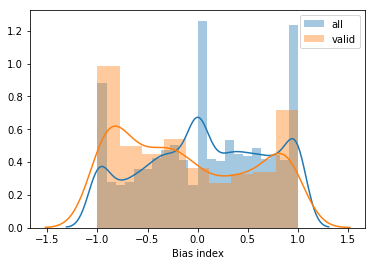

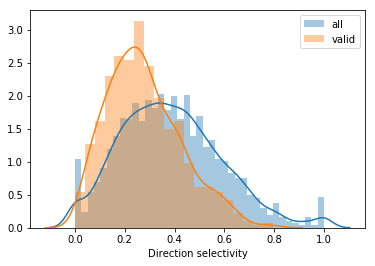

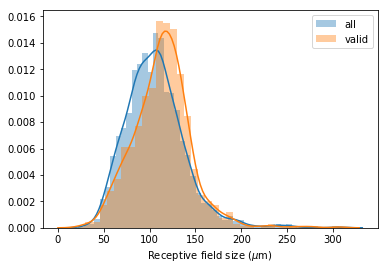

In [15]:
plt.figure()
sns.distplot(OOi, label='all')
sns.distplot(OOi[conditions_all], label='valid')
plt.xlabel('Bias index')
plt.legend()

plt.figure()
sns.distplot(DSi[:,0],label='all')
sns.distplot(DSi[conditions_all,0], label='valid')
plt.xlabel('Direction selectivity')
plt.legend()

plt.figure()
sx = np.mean((np.abs(STAs['fits'][:,3]),np.abs(STAs['fits'][:,4])),0)
sns.distplot(sx*42, label='all')
sns.distplot(sx[(~invalid_sta_inds)&(insta)]*42, label='valid')
plt.xlabel('Receptive field size ($\mu$m)')
plt.legend()


# Clustering

# Compare cut-off for clustering

In [16]:
# obtain Gap statistic
tss = np.arange(0.3,3,0.01) # threshold values to test
gaps = np.empty((2,2,tss.shape[0]))
NCs_gap = np.empty((2,2,tss.shape[0]))

ncls = np.arange(2,61,1)
metric_scores = np.empty((2,4,len(ncls)))
links_ward_ISI   = []
links_ward_SPIKE = []
mk_l = lambda dy: cluster.hierarchy.linkage(dy, method='ward')
for i in range(2):
    links_ward_ISI.append(mk_l(ISI_dist_ys_valid[i]))
    links_ward_SPIKE.append(mk_l(SPIKE_dist_ys_valid[i]))

for s in (0,1):
    for i_d,d in enumerate((ISI_dist_ys_valid[s],SPIKE_dist_ys_valid[s])):
        Nc, Wk, Nc_shuff, Wk_shuff, Dk, Dk_shuff, ts = eval_gap_scores(d,tss)
        gaps[s,i_d,:] = np.log(Wk_shuff)-np.log(Wk)
        NCs_gap[s,i_d,:] = Nc
    
    isidm = distance.squareform(ISI_dist_ys_valid[s])
    spkdm = distance.squareform(SPIKE_dist_ys_valid[s])
    for i,t in enumerate(ncls):
        fcls_isi = cluster.hierarchy.fcluster(links_ward_ISI[s], t=t, criterion='maxclust')
        fcls_spk = cluster.hierarchy.fcluster(links_ward_SPIKE[s], t=t, criterion='maxclust')
        metric_scores[s,0,i] = metrics.adjusted_mutual_info_score(fcls_isi,fcls_spk)
        metric_scores[s,1,i] = metrics.completeness_score(fcls_isi,fcls_spk)
        metric_scores[s,2,i] = metrics.adjusted_rand_score(fcls_isi,fcls_spk)  
    
for i,t in enumerate(ncls):
    fcls_0 = cluster.hierarchy.fcluster(links_ward_ISI[0], t=t, criterion='maxclust')
    fcls_1 = cluster.hierarchy.fcluster(links_ward_ISI[1], t=t, criterion='maxclust')
    metric_scores[0,3,i] = metrics.adjusted_mutual_info_score(fcls_0,fcls_1)
    fcls_0 = cluster.hierarchy.fcluster(links_ward_SPIKE[0], t=t, criterion='maxclust')
    fcls_1 = cluster.hierarchy.fcluster(links_ward_SPIKE[1], t=t, criterion='maxclust')
    metric_scores[1,3,i] = metrics.adjusted_mutual_info_score(fcls_0,fcls_1)
    

Full field ISI distance gap stat peak at 16.0 clusters
Full field SPIKE distance gap stat peak at 17.0 clusters
Chirp ISI distance gap stat peak at 18.0 clusters
Chirp SPIKE distance gap stat peak at 17.0 clusters
Full field mi score peak at 17 clusters
Chirp mi score peak at 28 clusters
ISI distance mi score peak at 17 clusters
SPIKE distance mi score peak at 28 clusters


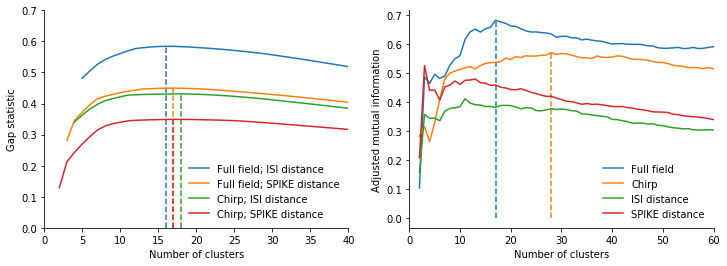

In [17]:
plt.figure(figsize=(12,4))
ax = plt.subplot(121)
s_labels = ('Full field','Chirp')
d_labels = ('ISI distance','SPIKE distance')
with plt.rc_context(rcParams):
    for s in (0,1):
        for d in (0,1):
            p = plt.plot(NCs_gap[s,d,:],gaps[s,d,:], label=s_labels[s]+'; '+d_labels[d])
            print(s_labels[s]+' '+d_labels[d]+' gap stat peak at '+str(NCs_gap[s,d,np.argmax(gaps[s,d])])+' clusters')
            plt.vlines(NCs_gap[s,d,np.argmax(gaps[s,d])],0,gaps[s,d,np.argmax(gaps[s,d])],linestyles='--',colors=p[0].get_c())
plt.xlim((0,40))
plt.ylim((0,0.7))
plt.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Number of clusters')
plt.ylabel('Gap statistic');

ax = plt.subplot(122)
m = 0 # use mutual info
with plt.rc_context(rcParams):
    for s in (0,1):
        p = plt.plot(ncls,metric_scores[s,m,:], label=s_labels[s])
        print(s_labels[s]+' mi score peak at '+str(ncls[np.argmax(metric_scores[s,m,:])])+' clusters')
        plt.vlines(ncls[np.argmax(metric_scores[s,m,:])],0,metric_scores[s,m,np.argmax(metric_scores[s,m,:])],linestyles='--',colors=p[0].get_c())
    for s in (0,1):
        p = plt.plot(ncls,metric_scores[s,3,:], label=d_labels[s])
        print(d_labels[s]+' mi score peak at '+str(ncls[np.argmax(metric_scores[s,m,:])])+' clusters')
#         plt.vlines(ncls[np.argmax(metric_scores[s,3,:])],0,metric_scores[s,3,np.argmax(metric_scores[s,3,:])],linestyles='--',colors=p[0].get_c())
plt.xlim((0,60))
# plt.ylim((0,0.7))
plt.legend(frameon=False)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.xlabel('Number of clusters')
plt.ylabel('Adjusted mutual information');

t_best_ff = ncls[np.argmax(metric_scores[0,m,:])]
t_best_chirp = ncls[np.argmax(metric_scores[1,m,:])]

if SAVE_FIGS:
    plt.savefig('clusters_comparison.pdf', bbox_inches='tight')

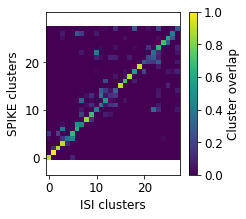

In [18]:
stim = 1
t = t_best_chirp
fcls = []
fcls.append(cluster.hierarchy.fcluster(links_ward_ISI[stim], t=t, criterion='maxclust'))
fcls.append(cluster.hierarchy.fcluster(links_ward_SPIKE[stim], t=t, criterion='maxclust'))

cnf_matrix = confusion_matrix(fcls[0], fcls[1], labels=np.arange(1,t+1))
normed_cnf = cnf_matrix.astype('float') / cnf_matrix.sum(axis=1)[:, np.newaxis]

with plt.rc_context(rcParams):
    plt.figure(figsize=(3,3))
    plt.imshow(normed_cnf[np.argmax(normed_cnf,axis=0),:],origin='lower')
    plt.axis('equal')
    cb = plt.colorbar()
    cb.set_label('Cluster overlap');
    plt.xlabel('ISI clusters')
    plt.ylabel('SPIKE clusters')
    plt.xticks((0,10,20))
    plt.yticks((0,10,20))
    
if SAVE_FIGS:
    plt.savefig('clusters_MI.pdf', bbox_inches='tight')

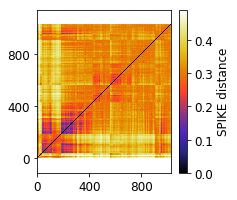

In [19]:
# code credit: stackexchange I think
def seriation(Z,N,cur_index):
    if cur_index < N:
        return [cur_index]
    else:
        left = int(Z[cur_index-N,0])
        right = int(Z[cur_index-N,1])
        return (seriation(Z,N,left) + seriation(Z,N,right))
    
def compute_serial_matrix(dist_mat,method="ward"):
    sq_dist_mat = squareform(dist_mat)
    N = sq_dist_mat.shape[0]
    res_linkage = cluster.hierarchy.linkage(dist_mat, method=method)
    #linkage(flat_dist_mat, method=method,preserve_input=True)
    res_order = seriation(res_linkage, N, N + N-2)
    seriated_dist = np.zeros((N,N))
    a,b = np.triu_indices(N,k=1)
    seriated_dist[a,b] = sq_dist_mat[ [res_order[i] for i in a], [res_order[j] for j in b]]
    seriated_dist[b,a] = seriated_dist[a,b]
    
    return seriated_dist, res_order, res_linkage

sorted_normed_cnf, res_order, res_linkage = compute_serial_matrix(SPIKE_dist_ys_valid[1],method='ward')
with plt.rc_context(rcParams):
    plt.figure(figsize=(3,3))
    plt.imshow(sorted_normed_cnf, cmap=plt.cm.CMRmap, origin='lower')
    cb = plt.colorbar()
    cb.set_label('SPIKE distance')
    plt.axis('equal')
    plt.xticks((0,400,800))
    plt.yticks((0,400,800))
    
if SAVE_FIGS:
    plt.savefig('clusters_distance_matrix_clustered_SPIKE.pdf', bbox_inches='tight')

# Final clustering

Distance 28.00
Number of (flat) clusters: 28
Mean Silhouette Coefficient: -0.00
CPU times: user 3.78 s, sys: 368 ms, total: 4.15 s
Wall time: 779 ms


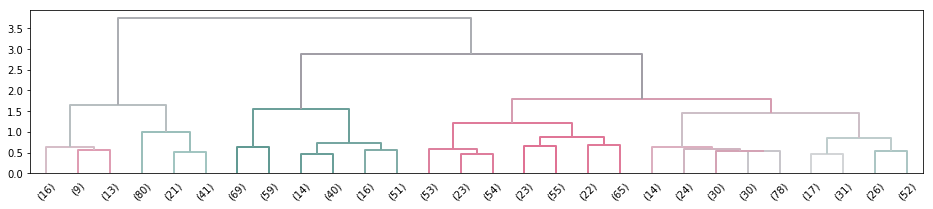

In [20]:
%%time

t = t_best_chirp
new_distances = SPIKE_dist_ys_valid[1]

l = cluster.hierarchy.linkage(new_distances, method='ward')
fcls = cluster.hierarchy.fcluster(l, t=t, criterion='maxclust')
n_flat_clusters = np.unique(fcls).shape[0]

print("Distance %.2f\nNumber of (flat) clusters: %d" % (t,n_flat_clusters))
silhouettes = metrics.silhouette_samples(distance.squareform(new_distances),fcls,metric='precomputed')
print("Mean Silhouette Coefficient: %.2f" % np.average(silhouettes))

### plot dendrogram

plt.figure(figsize=(16,3))

## set things up for coloured dendrogram
n = 41
pal = sns.diverging_palette(180,359,sep=1,n=n)
OOi_cspace = np.linspace(-1,1,n)
OOi_c_func = lambda i: pal[np.searchsorted(OOi_cspace,OOi[conditions_all][i])]
DSi_cspace = np.linspace(0,1,n)
DSi_c_func = lambda i: pal[np.searchsorted(DSi_cspace,DSi[conditions_all][i,0])]

def create_colors_for_linkage(Z,data_len,base_col_func):
    colors = []
    for i1,i2,d,c in Z:
        if i1 >= data_len:
            c1 = colors[int(i1)-data_len]
        else:
            c1 = base_col_func(int(i1))
            
        if i2 >= data_len:
            c2 = colors[int(i2)-data_len]
        else:
            c2 = base_col_func(int(i2))
        new_c = sns.blend_palette([c1,c2],n_colors=3).as_hex()[1]
        colors.append(new_c)
    return colors

cs = create_colors_for_linkage(l,l.shape[0]+1,OOi_c_func)

# calculate labels
n = n_flat_clusters
T = np.unique(fcls)
labels=list('' for i in range(20*n))
for i in range(n):
    labels[i]=str(i)+ ',' + str(T[i])

with plt.rc_context({'lines.linewidth': 2, 'font.size':10}):
    dend = cluster.hierarchy.dendrogram(l, p=n, no_labels=False, leaf_font_size=10, color_threshold=t, 
                                        distance_sort='ascending', link_color_func=lambda k: cs[k-l.shape[0]-1], 
                                        truncate_mode='lastp', labels = labels, show_leaf_counts=True)

if SAVE_FIGS:
    plt.savefig('clustered_dendrogram.pdf', bbox_inches='tight')

In [21]:
# compute averages for each cluster
unit_mean_OOi = np.zeros(np.unique(fcls).shape[0])
unit_mean_DSi = np.zeros(np.unique(fcls).shape[0])
for c in range(np.unique(fcls).shape[0]):
    inds = np.where(fcls == c+1)[0]
    unit_mean_OOi[c] = np.mean(OOi[conditions_all][inds])    
    unit_mean_DSi[c] = np.mean(DSi[conditions_all][inds][:,0])
    
max_num_clustersx = n_flat_clusters
# show_order = np.argsort(unit_mean_OOi)
show_order = np.unique(fcls)[::-1]-1
max_num_clusters = np.unique(fcls).shape[0]

palette = sns.hls_palette(max_num_clusters,l=0.6,s=0.6)

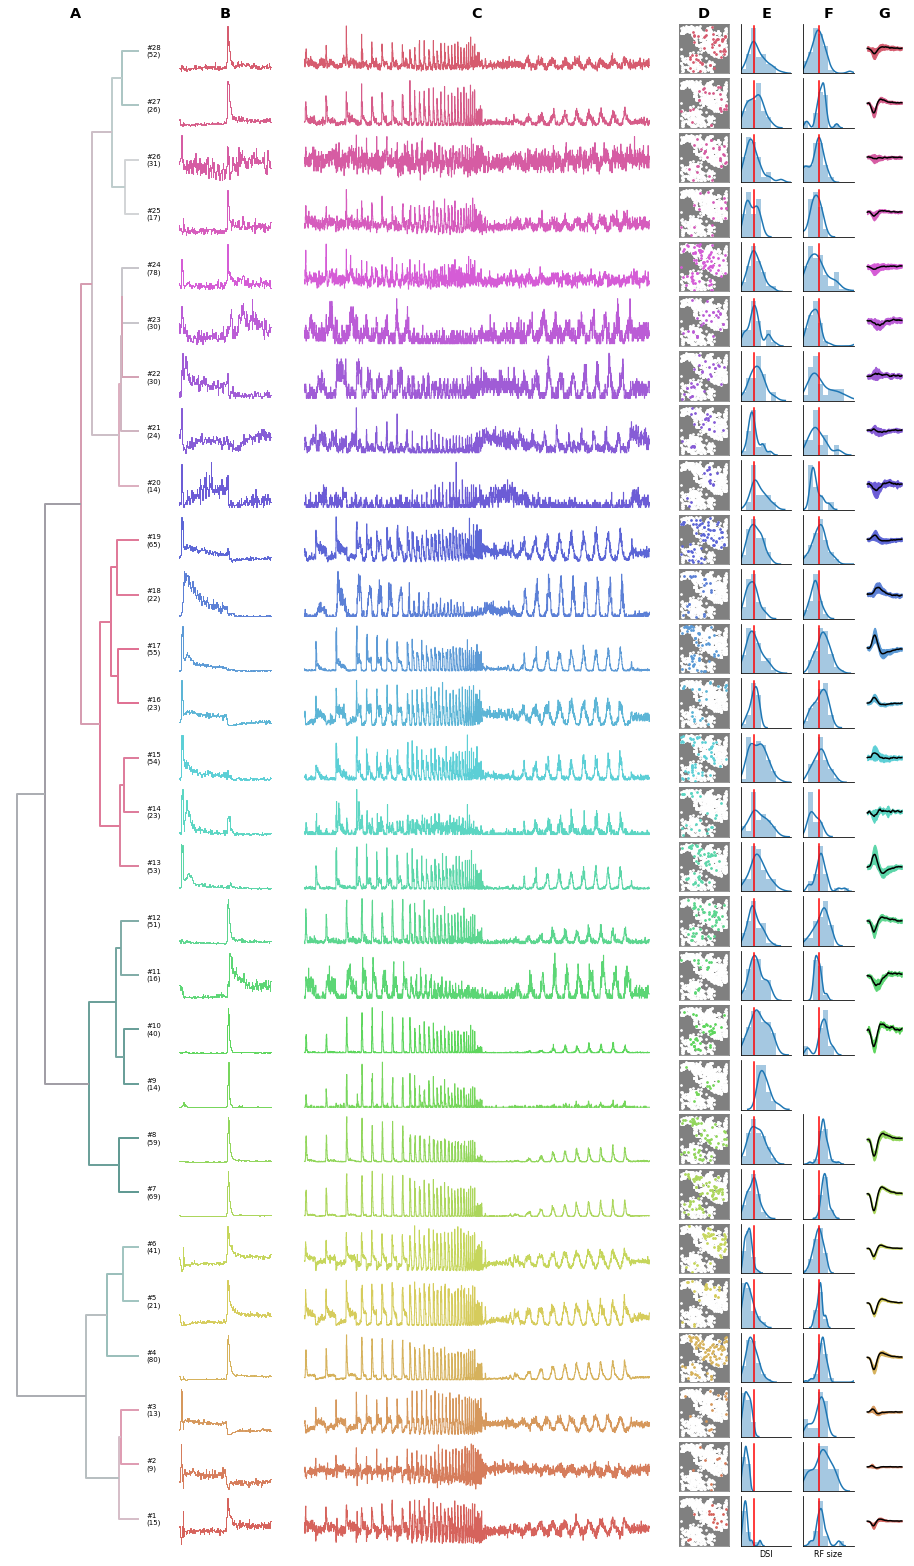

In [22]:
import matplotlib.gridspec as gridspec

plt.figure(figsize=(16,max_num_clustersx*1))
# plt.figure(figsize=(9,max_num_clustersx*1.7/4.8))

plot_stims = [0,1]

fs = 12#24

labels=list('' for i in range(n))
for i in range(n):
    labels[i] = '#' + str(T[i]) + '\n(' + str(np.count_nonzero(np.where(fcls==T[i]))) + ')'
    
# plot_widths = [1.2,0.8,3,0.4,0.4, 0.4, 0.4]
plot_widths = [1.2,0.8,3,0.4,0.4, 0.4, 0.3]

gs = gridspec.GridSpec(max_num_clustersx, 7, width_ratios = plot_widths, wspace=0.1, hspace=0.1)

bins = 20 # ms

cids = np.where(conditions_all)[0]
has_sta = np.zeros_like(conditions_all).astype(dtype=bool)
has_sta[STAs['units'].value] = True
sta_inds = np.zeros(np.sum(conditions_all), dtype(int))
sta_inds[has_sta[conditions_all]] = np.where(np.isin(STAs['units'].value, np.where(conditions_all&has_sta)[0]))[0]
has_sta = has_sta[conditions_all]
mean_rf_size = np.median((np.abs(STAs['fits'][has_sta,3]),np.abs(STAs['fits'][has_sta,3])))

ylims = [(0,40),(0,10)]
    
for i, c in enumerate(show_order):

    n_units = np.where(fcls == c+1)[0].shape[0]
    for ci, stimid in enumerate(plot_stims):
        sts = Stimuli[0]['SpikeTrains'][stimid][conditions_all][np.where(fcls == c+1)]
        if stimid == 0:
            txt = "Cluster %d (%d units)" % (c+1,n_units)
        elif stimid == 1:
            t_sils = silhouettes[np.where(fcls == c+1)]
            t_ooi  = OOi[conditions_all][np.where(fcls == c+1)]
            txt = "Avg. OOi: %.2f±%.2f    Avg. Silhouette Coeff.: %.2f±%.2f" % (np.average(t_ooi),np.std(t_ooi),np.average(t_sils),np.std(t_sils))
        elif stimid == 5:
            t_dsi = DSi[conditions_all][np.where(fcls == c+1)][:,0]
            txt = "Avg. DSi: %.2f±%.2f" % (np.average(t_dsi),np.std(t_dsi))
        else:
            txt = ""
        if (ci == 0) & (i==0):
            txt = 'B'
        elif (ci == 1) & (i==0):
            txt = 'C'
        else:
            txt = None
        with plt.rc_context({'font.size':fs, 'axes.titleweight': 'bold'}):
            ax = plt.subplot(gs[i,ci+1])
            plotPSTHs(ax,sts,txt,bins,palette[c], show_sd=False, lw=1)
            plt.xticks(())
            plt.yticks(())
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['left'].set_visible(False)
            ax.spines['right'].set_visible(False)

        
    with plt.rc_context({'font.size':fs, 'axes.titleweight': 'bold'}):
        ax = plt.subplot(gs[i,4])
        t_dsi = DSi[conditions_all][np.where(fcls == c+1)][:,0]
        sns.distplot(t_dsi,bins=np.arange(0,0.8,0.1),kde=True, norm_hist=True)
        if i == 0:
            txt = 'E'
        else:
            txt = ''
        t_dsi = np.median(DSi[conditions_all][:,0])
        plt.plot((t_dsi, t_dsi),ax.get_ylim(),'r')
        ax.set_title(txt)
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_xlim((0,1.0))
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        if i==len(show_order)-1:
            plt.xlabel('DSI', fontsize=8)
    
    with plt.rc_context({'axes.facecolor': 'grey','axes.edgecolor': 'grey','font.size':fs, 'axes.titleweight': 'bold'}):
        ax = plt.subplot(gs[i,3])
        n_units = np.where(fcls == c+1)[0].shape[0]
        ax.scatter(ClusterLoc[0][0,conditions_all][np.where(fcls != c+1)],
                   ClusterLoc[0][1,conditions_all][np.where(fcls != c+1)], c='w', s=3)
        ax.scatter(ClusterLoc[0][0,conditions_all][np.where(fcls == c+1)],
                   ClusterLoc[0][1,conditions_all][np.where(fcls == c+1)], s=3, c=palette[c])
        if i == 0:
            txt = 'D'
        else:
            txt = ''
        ax.set_title(txt)
        ax.set_xlim((-1,65))
        ax.set_ylim((-1,65))
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_aspect(1)

    with plt.rc_context({'font.size':fs, 'axes.titleweight': 'bold'}):
        inds = fcls==c+1
        usable_stas = sta_inds[has_sta&inds]
        if len(usable_stas)>0:
            ax = plt.subplot(gs[i,5])
            sx = np.mean((np.abs(STAs['fits'][usable_stas,3]),np.abs(STAs['fits'][usable_stas,4])),0)
            sns.distplot(sx[(sx<10)&(sx>0)],bins=np.arange(0,6,0.5),kde=True, norm_hist=True)
            plt.plot((mean_rf_size,mean_rf_size),ax.get_ylim(),'r')
            if i == 0:
                txt = 'F'
            else:
                txt = ''
            ax.set_title(txt)
            ax.set_xticks(())
            ax.set_yticks(())
            ax.set_xlim((1,6))
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
        if i==len(show_order)-1:
            plt.xlabel('RF size', fontsize=8)

    with plt.rc_context({'font.size':fs, 'axes.titleweight': 'bold'}):
        ax = plt.subplot(gs[i,6])
        if len(usable_stas)>0:
            tmp_sta = np.array([get_sta_at_peak(STAs['STAs'][i]) for i in usable_stas])
            x = np.arange(tmp_sta.shape[1])
            plt.fill_between(x, np.mean(tmp_sta,0)-np.std(tmp_sta,0), np.mean(tmp_sta,0)+np.std(tmp_sta,0), color=palette[c])
            plt.plot(x,np.mean(tmp_sta,0),'k')
        if i == 0:
            txt = 'G'
        else:
            txt = ''
        ax.set_title(txt)
        ax.set_xticks(())
        ax.set_yticks(())
        plt.ylim((-0.3,0.3))
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
ax = plt.subplot(gs[:,0])
p = ax.get_position()
p.x1 = p.x1-0.02
ax.set_position(p)
with plt.rc_context({'lines.linewidth': 2, 'font.size':fs, 'axes.titleweight': 'bold'}):
    dend = cluster.hierarchy.dendrogram(l, p=n, no_labels=False, leaf_font_size=7, color_threshold=t, 
                                        distance_sort='none', link_color_func=lambda k: cs[k-l.shape[0]-1], 
                                        truncate_mode='lastp', labels = labels, show_leaf_counts=True, orientation='left')

    ax.set_title("A")
    ax.set_yticklabels(labels)
    ax.set_xticks(())
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['right'].set_visible(False)

if SAVE_FIGS:
    plt.savefig('clusters_summary_chirp_SPIKE.pdf', bbox_inches='tight')

In [23]:
# collect various neuron properties

sils = []
ooi = []
dsi = []
rfs = []

for i, c in enumerate(show_order[::-1]):
    n_units = np.where(fcls == c+1)[0].shape[0]
    t_sils = silhouettes[np.where(fcls == c+1)]
    sils.append(t_sils)
    t_ooi  = OOi[conditions_all][np.where(fcls == c+1)]
    ooi.append(t_ooi)
    t_dsi = DSi[conditions_all][np.where(fcls == c+1)][:,0]
    dsi.append(t_dsi)
    
    inds = fcls==c+1
    usable_stas = sta_inds[has_sta&inds]
    if len(usable_stas)>0:
        sx = np.mean((np.abs(STAs['fits'][usable_stas,3]),np.abs(STAs['fits'][usable_stas,4])),0)
        rfs.append(sx)
    else:
        rfs.append(())


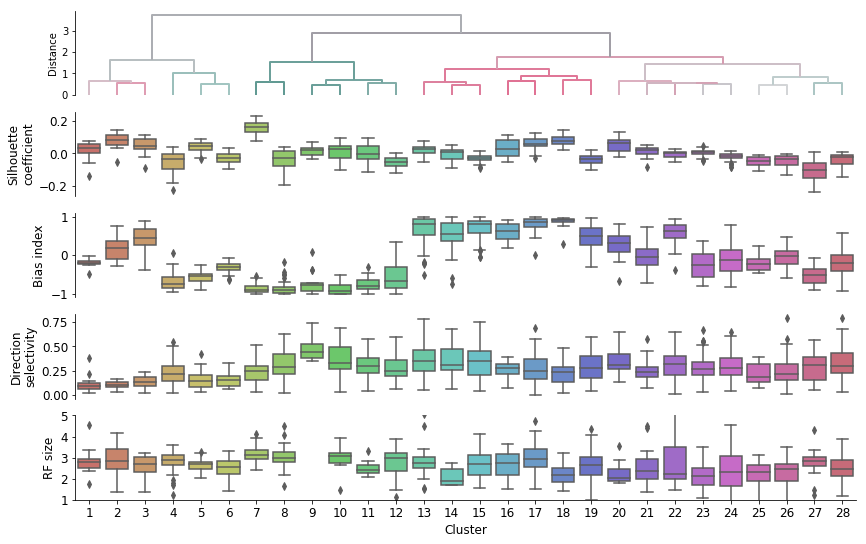

In [24]:
plt.figure(figsize=(14,9))

gs = gridspec.GridSpec(5, 1)
ax = plt.subplot(gs[0,0])
dd={'lines.linewidth': 2}
dd.update(rcParams)
with plt.rc_context(dd):
    dend = cluster.hierarchy.dendrogram(l, p=n, no_labels=True, leaf_font_size=16, color_threshold=t, 
                                        distance_sort='none', link_color_func=lambda k: cs[k-l.shape[0]-1], 
                                        truncate_mode='lastp', labels = None, show_leaf_counts=True, 
                                        orientation='top')
    plt.ylabel('Distance')
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)


data_labels = ('Silhouette\ncoefficient', 'Bias index', 'Direction\nselectivity', 'RF size')
with plt.rc_context(rcParams):
    for i,data in enumerate((sils,ooi,dsi,rfs)):
        plt.subplot(gs[i+1,0])
        ax = sns.boxplot(data=data, palette=np.array(palette), orient= 'v')
        plt.ylabel(data_labels[i])
        if i<3:
            plt.xticks(())
            ax.spines['top'].set_visible(False)
            ax.spines['bottom'].set_visible(False)
            ax.spines['right'].set_visible(False)
        else:
            ax.set_xticklabels(show_order[::-1]+1)
            ax.spines['top'].set_visible(False)
            ax.spines['right'].set_visible(False)
#     ax = sns.swarmplot(data=data,palette=np.array(palette), size=3)
plt.ylim((1,5))
plt.xlabel('Cluster')
if SAVE_FIGS:
    plt.savefig('clusters_stats_chirp_SPIKE.pdf', bbox_inches='tight')

units:  [ 267  350  365  378  385  393  415  433  446  453  460  493  498  512
  516  517  525  529  537  545  553  568  570  585  616  650  686  697
  703  708  713  719  731  737  750  764  782  788  799  824  835  836
  839  862  867  874  875  896  905  925  931  979  990  998 1007]


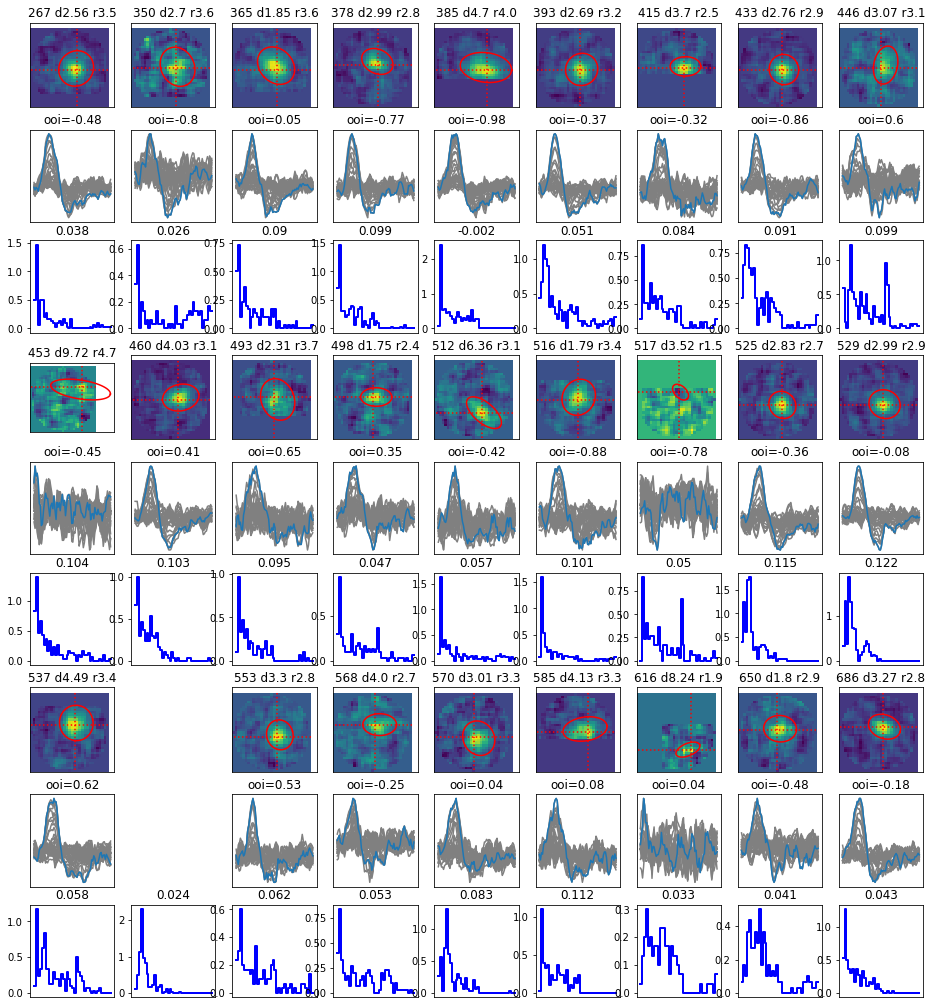

In [25]:
def plot_units(inds, num=None):
    plt.figure(figsize=(16,18))
    usable_stas = sta_inds[has_sta&inds]
    spinds = np.where(inds&has_sta)[0]
    for ii,i in enumerate(np.where(inds)[0][:27]):
        if has_sta[i]:
            plt.subplot(9,9,(ii%9)+1+3*9*(ii//9))
            si = sta_inds[i]
            po = STAs['fits'][si]
            plot_sta_2d(STAs['STAs'][si], po, verbose=False)
            plt.xticks(())    
            plt.yticks(())
            plt.title(str(i)+' d'+str(np.round(np.sqrt(np.sum((STAs['fits'][si][0:2]-np.array([15,15]))**2)),2))+' r'+
                      str(np.round(np.mean(STAs['fits'][si][3:5]),1)))

            plt.subplot(9,9,(ii%9)+1+3*9*(ii//9)+9)
            plot_sta_peak_crossect(STAs['STAs'][si], (0,STAs['STAs'][0].shape[0],1), Sampling, verbose=False, direction=2)
            plot_sta_peak(STAs['STAs'][si], (0,STAs['STAs'][0].shape[0],1), Sampling, verbose=False)
            plt.title('ooi='+str(np.round(OOi[i],2)))
            plt.xticks(())
            plt.yticks(())
            plt.xlabel('')

        ax = plt.subplot(9,9,(ii%9)+1+3*9*(ii//9)+18)
        sts = Stimuli[0]['SpikeTrains'][0][conditions_all][i]
        plotPSTHs(ax,sts,'',100,show_ticks=True)#, ylim=(0,2))
        if num is not None:
            plt.title(str(np.round(num[ii],3)))
        plt.xticks(())

c = 17 # select the cluster number to show
inds = fcls == c
print('units: ',np.where(inds)[0])
plot_units(inds, sils[c-1])


In [26]:
psths = [] 
for sts in Stimuli[0]['SpikeTrains'][1][conditions_all]:
    xs,ys = getPSTHs((sts,),bs=50)
    psths.append(ys[0])
psths = np.array(psths)

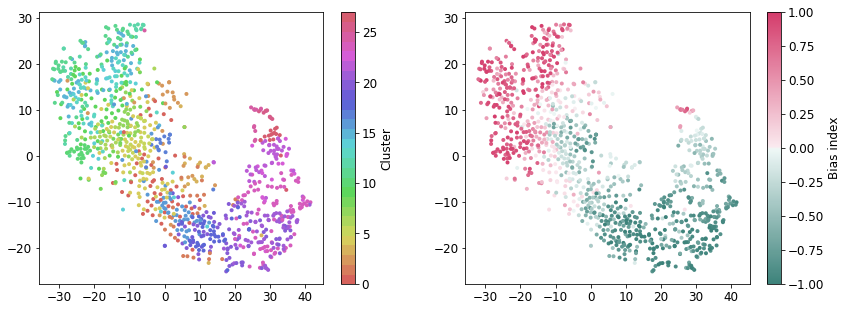

In [27]:
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize
from sklearn.preprocessing import robust_scale
from matplotlib.colors import ListedColormap

t_ = t_best_chirp
new_distances_ = SPIKE_dist_ys_valid[1]
l_ = cluster.hierarchy.linkage(new_distances_, method='ward')
fcls_ = cluster.hierarchy.fcluster(l_, t=t_, criterion='maxclust')
n_flat_clusters_ = np.unique(fcls_).shape[0]
show_order_ = np.unique(fcls_)[::-1]-1

model = TSNE(n_components=2, random_state=0, perplexity=30)#,init='pca')
proj = model.fit_transform(psths) 

with plt.rc_context(rcParams):
    plt.figure(figsize=(14,5))
    ax = plt.subplot(121)
    # ax.set_facecolor((0.3,0.3,0.3))
    s = plt.scatter(proj[:,0],proj[:,1],s=16,lw=0,c=show_order_[fcls_-1],
                    cmap=ListedColormap(sns.hls_palette(n_flat_clusters_,l=0.6,s=0.6).as_hex()))
    cb = plt.colorbar(s)
    cb.set_label('Cluster')
    # plt.axis('equal')
    plt.grid(False)
    ax = plt.subplot(122)
    # ax.set_facecolor((0.3,0.3,0.3))
    p = plt.scatter(proj[:,0],proj[:,1],s=16,lw=0,c=np.array(((OOi[conditions_all]))),
                    cmap=sns.diverging_palette(180,359,sep=1,n=32,as_cmap=True))
    cb = plt.colorbar(p)
    cb.set_label('Bias index')
    # plt.axis('equal')
    plt.grid(False)

if SAVE_FIGS:
    plt.savefig('clusters_tsne_chirp_SPIKE.pdf', bbox_inches='tight')